<font  style="font-size: 4rem; color: darkviolet"> Transfer Learning with MobileNetV2 </font>

AA - 2022/23 - TP8

*This assignement is inspired by the Deep Learning course on Coursera by Andrew Ng, Stanford University, for which we are thankful.*

In this assignment, you'll be using transfer learning on a pre-trained CNN to build an Alpaca/Not Alpaca classifier.

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. The network you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

For more insights, please refer to the lecture material.

Objectives:

- Create a dataset from a directory
- Preprocess and augment data using the Sequential API
- Adapt the pre-trained MobileNet model to the new data using the Functional API 
- Fine-tune the final layers of the classifier to further improve the accuracy of the model


## Table of Contents
- [1 - The Dataset](#1)
- [2 - Pre-process and Augment Training Data](#2) 
    - [Exercise 2.1 - data_augmenter](#ex-2.1)
- [3 - Using MobileNetV2 for Transfer Learning](#3)
    - [3.1 - The MobileNetV2 architecture](#3-1)
    - [3.2 - Layer Freezing with the Functional API](#3-2)
        - [Exercise 3.2.1 - alpaca_model](#ex-3.2.1)
    - [3.3 - Fine-tuning the Model](#3.3)
        - [Exercise 3.3.1](#ex-3.3.1)        

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

<a name='1'></a>
# <font color='darkviolet'> 1 - The Dataset
       
When it comes to training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is usually a straightforward and efficient process. Use `image_dataset_from_directory()` to read data from the directory containing the image files, and create both the training and validation datasets.

If you wish to specify a validation split, you'll need to set the `subset` for each portion. Assign the value `subset='training'` to the training set and `subset='validation'` to the validation set.

Additionally, it's important to ensure that your training and validation sets do not overlap. To achieve this, make sure to set your seeds to match each other. This will help ensure that the random sampling for each set is consistent and reproducible, resulting in more reliable model evaluation.

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "data/dataset/"
# Use a random seed of 42 to ensure the same splits each time the code is run.
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


2023-04-19 18:26:48.062812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-19 18:26:48.063334: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
print(train_dataset.element_spec)
print(validation_dataset.element_spec)

(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


**Note:** The original dataset has some mislabelled images.

Let's take a look at some of the images from the training set: 

2023-04-19 18:26:48.423919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [262]
	 [[{{node Placeholder/_4}}]]
2023-04-19 18:26:48.424440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [262]
	 [[{{node Placeholder/_0}}]]


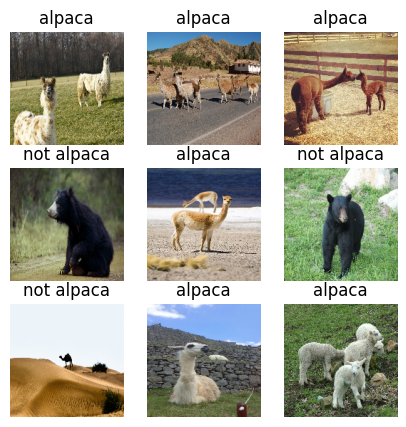

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### <font color='blue'> Q1.1 Describe your dataset.

> **Q1.1**: The dataset consists of images of alpacas and non-alpacas. It is divided into training and validation sets with a 80/20 split. The `image_dataset_from_directory()` function is used to read data from the directory containing the image files. The training set has been shuffled, with a batch size of 32 and the images have been resized to (160, 160). The validation set has been shuffled as well, with the same batch size and image size, and was created using the `validation_split` argument in `image_dataset_from_directory()`. The class names are "alpaca" and "not_alpaca". The dataset has some mislabelled images.

<a name='2'></a>
# <font color='darkviolet'> 2 - Preprocess and Augment Training Data   
    
Using `prefetch()` is an effective way to prevent a potential memory bottleneck that can occur when reading from disk. This method creates a source dataset from your input data and applies a transformation to preprocess it. By iterating over the dataset one element at a time, the `prefetch()` method sets aside some data and keeps it ready for when it's needed. Because the iteration is streaming, the data doesn't need to fit into memory.

You have the option to manually set the number of elements to prefetch, or you can use `tf.data.experimental.AUTOTUNE` to automatically choose the parameters. By using AUTOTUNE, TensorFlow automatically tunes the prefetch value at runtime. 

To increase diversity in the training set and help your model better learn the data, it's common practice to **augment the images** by transforming them. This can include randomly flipping and rotating them. With Keras' Sequential API, data augmentation is straightforward, with built-in and customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.

For further information on data augmentation, please refer to the official Keras documentation https://www.tensorflow.org/tutorials/images/data_augmentation.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='ex-2.1'></a>
### <font color='blue'> Exercise 2.1 - data_augmenter

Implement a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [ ]:
def data_augmenter():
    '''
    Creates a Sequential model composed of 2 layers for data augmentation.
    Returns:
        tf.keras.Sequential: a model for data augmentation.
    '''
    # Create an empty Sequential model for data augmentation
    data_augmentation = tf.keras.Sequential()

    # Add a RandomFlip layer to randomly flip images horizontally
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
    
    # Add a RandomRotation layer to randomly rotate images by a factor of 0.2
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
    
    return data_augmentation

In [ ]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')

All tests passed!


Take a look at how a single image from the training set can be transformed into nine different variations with just a few lines of code. 

By applying simple transformations such as flipping and rotating, we can create a diverse set of images for the model to learn from. These data augmentations can help improve the model's ability to generalize and make accurate predictions on new, unseen images.

2023-04-19 18:36:32.566248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [262]
	 [[{{node Placeholder/_0}}]]
2023-04-19 18:36:32.566693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [262]
	 [[{{node Placeholder/_4}}]]


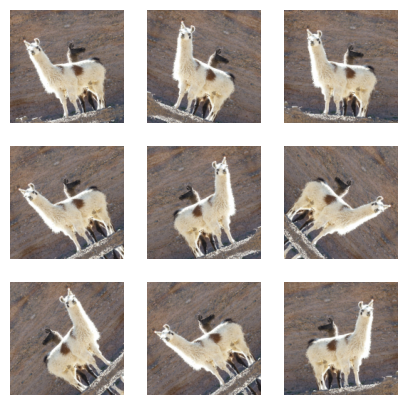

In [44]:
# Create a data augmentation model
data_augmentation = data_augmenter()

# Take one image from the training dataset
for image, _ in train_dataset.take(1):
    
    # Create a plot with a 3x3 grid of images
    plt.figure(figsize=(5, 5))
    
    # Select the first image from the batch
    first_image = image[0]
    
    # Apply data augmentation to the first image and plot the result
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # Apply data augmentation to the image
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        
        # Display the augmented image
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, you'll apply a useful tool from the MobileNet application in TensorFlow to normalize your input. Since the pre-trained MobileNetV2 model was originally trained using normalization values in the range of [-1, 1], it's considered best practice to use the same normalization standard for your input data. You can achieve this easily by using the `tf.keras.applications.mobilenet_v2.preprocess_input` function.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## <font color='darkviolet'> 3 - Using MobileNetV2 for Transfer Learning

MobileNetV2 is a convolutional neural network architecture that was originally trained on the ImageNet dataset. It was specifically designed to provide fast and computationally efficient performance on mobile and other low-compute devices. The network consists of 155 layers and is highly effective for object detection and image segmentation tasks, as well as classification tasks like the one you're working on.

<a name='3-1'></a>
### <font color='darkviolet'> 3.1 - The MobileNetV2 architecture
    
MobileNetV2's architecture has three defining characteristics (as seen in last lecture):

*   Depthwise separable conv layers
*   Expansion layers
*   Shortcut connections between bottleneck blocks

Let's train your base model using all the layers from the pre-trained model. 

Similarly to how you re-used the pre-trained normalization values MobileNetV2 was trained on, you'll load the pre-trained weights from ImageNet by specifying `weights='imagenet'`. 

**Note** the last layer in this model is the so called top layer and it is responsible of the classification in the model

In [46]:
IMG_SHAPE = IMG_SIZE + (3,) #for the RGB color channels
print("image shape:",IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

image shape: (160, 160, 3)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_2
predictions


Notice some of the layers in the summary like `Conv2D` and `DepthwiseConv2D` and how they follow the progression of expansion to depthwise convolution to projection. In combination with BatchNormalization and ReLU, these make up the bottleneck blocks.

> The image shape is: (160, 160, 3) because the images have been resized to (160, 160) and the images are RGB images.


####  <font color='blue'> Q3.1.1: What is the total number of blocks present in the MobileNetV2 architecture?</font>

> **Q3.1.1:** Based on the output of the summary, we have a total of 16 blocks in the MobileNetV2 architecture.

#### <font color='blue'> Q3.1.2: In the MobileNetV2 architecture, what is the role of the expansion layer and how does it contribute to the overall model performance?</font>

> **Q3.1.2:** In the MobileNetV2 architecture, the expansion layer is responsible for increasing the dimensionality of the input tensor before applying the depthwise convolution. This is achieved through a 1x1 convolution operation. The purpose of the expansion layer is to provide more representational power to the model, allowing it to learn more complex and detailed features from the input images. By incorporating the expansion layer, MobileNetV2 is able to achieve better performance than its predecessor, MobileNetV1, while maintaining the same level of computational efficiency.
        
#### <font color='blue'> Q3.1.3: What is the significance of the depthwise separable convolution layer in the MobileNetV2 architecture?</font>
    
> **Q3.1.3:** The depthwise separable convolution layer in the MobileNetV2 architecture is significant because it is a computationally efficient alternative to the traditional convolutional layer. The depthwise convolution step performs a spatial convolution on each input channel separately, while the pointwise convolution combines the resulting output channels. This approach significantly reduces the number of computations required compared to a traditional convolutional layer. In MobileNetV2, the use of depthwise separable convolutions allows for a compact and efficient model that is well-suited for mobile and other low-compute devices.

#### <font color='blue'> Q3.1.4: How is the skip connection used in the MobileNetV2 architecture? Can you locate it in the model summary?</font>

> **Q3.1.4:**In the MobileNetV2 architecture, the skip connection is used to connect the input of a block to the output of a bottleneck block that follows it. This helps to improve gradient flow and information propagation throughout the network, which can improve the model's ability to learn features and generalize to new data.
> 
> The skip connections can be seen in the model summary as "Add" layers that connect the output of a bottleneck block to the input of the next block. For example, in the summary output shown in the notebook, we can see skip connections between layers "block_1_add" and "block_2_add", "block_3_add" and "block_4_add", and so on.

Next, choose the first batch from the dataset and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


#### <font color='blue'> Q3.1.5 What do the numbers 32 and 1000 refer to ?

In [ ]:
# Shows the label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1], dtype=int32)>

The predictions returned by the base model below follow this format: first the class number, then a human-readable label, and last the probability of the image belonging to that class. There are two of these returned for each image in the batch - the top two probabilities returned for that image.

In [ ]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n02504458', 'African_elephant', 0.55354935),
  ('n02504013', 'Indian_elephant', 0.32803378)],
 [('n02437616', 'llama', 0.9278837),
  ('n02098286', 'West_Highland_white_terrier', 0.0057286983)],
 [('n02110341', 'dalmatian', 0.3055607),
  ('n02100735', 'English_setter', 0.049685854)],
 [('n01518878', 'ostrich', 0.9543057),
  ('n02437312', 'Arabian_camel', 0.0016175574)],
 [('n01518878', 'ostrich', 0.9294674), ('n02018795', 'bustard', 0.003946679)],
 [('n02437312', 'Arabian_camel', 0.2954119),
  ('n02134084', 'ice_bear', 0.043125294)],
 [('n01883070', 'wombat', 0.22639108), ('n02442845', 'mink', 0.21543229)],
 [('n02012849', 'crane', 0.2215077), ('n02013706', 'limpkin', 0.1487794)],
 [('n02109047', 'Great_Dane', 0.47226262),
  ('n02091134', 'whippet', 0.27052498)],
 [('n02441942', 'weasel', 0.08272871),
  ('n02443484', 'black-footed_ferret', 0.07844236)],
 [('n02509815', 'lesser_panda', 0.87813383),
  ('n02119022', 'red_fox', 0.002775904)],
 [('n02437616', 'llama', 0.9046037), ('n0151

You may notice that none of the labels say "alpaca". This is because the MobileNet was pre-trained over ImageNet tht doesn't have the correct classification labels for alpacas.

You can delete the top layer, which contains all the classification labels, and create a new classification layer.

<a name='3-2'></a>
## <font color='darkviolet'> 3.2 - Layer Freezing with the Functional API

In the next sections, you'll see how you can use a pre-trained model to modify the classifier task so that it's able to recognize alpacas. You can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classification layer
    * Train only one layer by freezing the rest of the network
    * A single neuron is enough to solve a binary classification problem
3. Freeze the base model and train the newly-created classification layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer ??

In [39]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                                   include_top=False,
                                                   weights='imagenet')

In [40]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

<a name='ex-3.2.1'></a>
### <font color='blue'> 3.2.1 Exercise - alpaca_model

In [41]:
from data.test_utils import summary

In [42]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter(), dropout_rate=0.2):
    """
    Define a binary classification model based on MobileNetV2.
    
    Args:
    image_shape -- Image width and height
    data_augmentation -- Data augmentation function
    dropout_rate -- Dropout rate
    
    Returns:
    A Keras model
    """
    
    # Define the input shape
    input_shape = image_shape + (3,)
    
    # Load the pre-trained MobileNetV2 model
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    
    # Freeze the base model by making it non trainable
    #TODO
    #base_model.trainable = ...

    # Create the input layer - same as the imageNetv2 input size
    #TODO
    #inputs = tf.keras.Input(...) 
    
    # Apply data augmentation to the inputs
    #TODO
    #x = ... if data_augmentation else ...
    
    # Preprocess the inputs
    #TODO
    #x = ...
    
    # Pass the inputs through the base model
    #TODO
    #base_model_output = ... 
    
    # Add new binary classification layers
    # Use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(base_model_output) 
    # Include dropout to avoid overfitting
    #TODO
    #x = tfl.Dropout(...)(...)
    # Create a prediction layer with one neuron
    #TODO
    #prediction_layer = ...
    
    # Connect the layers to define the model
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [43]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

NameError: name 'base_model_output' is not defined

In [ ]:
summary(model2)

In [ ]:
from data.test_utils import summary, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
 ['Sequential', (None, 160, 160, 3), 0],
 ['TFOpLambda', (None, 160, 160, 3), 0],
 ['TFOpLambda', (None, 160, 160, 3), 0],
#['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
#['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
 ['Functional', (None, 5, 5, 1280), 2257984],
 ['GlobalAveragePooling2D', (None, 1280), 0],
 ['Dropout', (None, 1280), 0, 0.2],
 ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation
    
comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)

The base learning rate has been set for you, so you can go ahead and compile the new model and run it for 5 epochs:

In [ ]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
class_names

The results are ok, but could be better. Next, try some fine-tuning.

<a name='3.3'></a>
### <font color='darkviolet'>  3.3 - Fine-tuning the Model

Fine-tune the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. The way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. 

Where the final layers actually begin is a a bit arbitrary, so feel free to play around with this number. The important point is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your current task.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved.

<a name='#ex-3.3.1'></a>
### <font color='blue'> 3.3.1 Exercise - fine_tuning

In [ ]:
# Select the base model and make it trainable
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
# TODO
# for layer in base_model.layers[...]:
#     layer.... = ...
    
# Define the loss function, optimizer, and evaluation metric
# TODO
# loss_function = ...
# optimizer = ...
# metrics=...

# Compile the model
# TODO
# model2.compile(...)

In [ ]:
assert type(loss_function) == tf.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### <font color='blue'> Q3.3.1 Describe your experiments and results. 

#### <font color='blue'> Q3.3.2 Describe how you can adapt a pre-trained classifier to new data and and how you can potentially improve its accuracy.